In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/Users/richardgrumitt/Documents/berkeley/NFMC_Jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import scipy
from scipy.stats import multivariate_normal as n_mvn
import corner
import torch
import warnings
import pickle

import torch.distributions
from nfmc_jax.DLA.base import PPDLMC, LatentDLA
from nfmc_jax.DLA.posterior import TorchPosterior
from nfmc_jax.DLA.debug import MultiStageDebugger
from nfmc_jax.flows.base import SINFInterface, RealNVPInterface, MAFInterface, RQNSFInterface, PPInterface
from nfmc_jax.utils.torch_distributions import gaussian_log_prob, Funnel

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)

/opt/homebrew/Caskroom/miniforge/base/envs/jax_cpu/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Sampling a 100-d noisy funnel

In [55]:
D = 100 # Latent variable dimensions (not NF latent space)
a = 3.
b = 0.5

torch.manual_seed(0)

theta_sample = 0
z_sample = torch.randn((D,))
z_sample = z_sample * np.exp(b * theta_sample)
data_sample = torch.distributions.MultivariateNormal(loc=z_sample, 
                                                     covariance_matrix=0.1**2*torch.eye(D)).sample()
print(data_sample.shape)

def log_like(x, data=data_sample):
    theta = x[:, 0]
    z = x[:, 1:]
    return torch.distributions.MultivariateNormal(loc=data,
                                                  covariance_matrix=0.1**2*torch.eye(D)).log_prob(z)
    
def log_prior(x):
    theta = x[:, 0]
    z = x[:, 1:]
    log_pi_theta = torch.distributions.Normal(loc=0, scale=a).log_prob(theta)
    mu_z = torch.zeros((z.shape[0], D))
    sd_z = torch.exp(b * theta).reshape(z.shape[0], 1) * torch.ones((z.shape[0], D))
    log_pi_z = torch.sum(torch.distributions.Normal(loc=mu_z, scale=sd_z).log_prob(z), dim=1)
    return log_pi_theta + log_pi_z

def prior_rvs(N):
    n01 = torch.randn((N, D + 1))
    theta = n01[:, 0] * a
    z = torch.zeros((N, D))
    for i in range(N):
        z[i, :] = n01[i, 1:] * torch.exp(b * theta[i])
    x = torch.cat([theta.reshape(N, 1), z], dim=1)
    return x

posterior = TorchPosterior(log_likelihood = lambda x: log_like(x),
                           log_prior = lambda x: log_prior(x))

initial_samples = prior_rvs(20)

torch.Size([100])


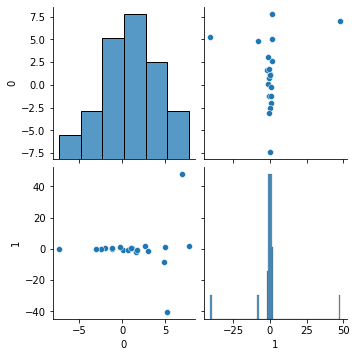

In [56]:
xdf = initial_samples[:, 0:2]
df = pd.DataFrame(xdf)
sns.pairplot(df)

In [54]:
truth_df = pd.read_csv('./fiducial_samples/noisy_funnel_100zD_sigma0p1.csv', index_col=0)

truth_x = np.empty((2000, D + 1))
truth_x[:, 0] = truth_df["('posterior', 'theta')"]
for i in range(D):
    truth_x[:, i + 1] = truth_df["('posterior', 'z[{0}]', {1})".format(i, i)]
    
#truth_x = truth_x[0::100, :]
print(np.shape(truth_x))
np.savetxt('./fiducial_samples/noise_funnel_100d_samples_sigma0p1.txt', truth_x)

FileNotFoundError: [Errno 2] No such file or directory: './fiducial_samples/noisy_funnel_100zD_sigma0p1.csv'

In [57]:
flow_interface = SINFInterface()
flow_interface.create_flow(x=initial_samples,
                           val_frac=0.25,
                           iteration=None,
                           bounds=None,
                           alpha=(0, 0.98),
                           NBfirstlayer=True,
                           verbose=False,
                           M=None,
                           Whiten=False,
                           Whiten_with_weights=False,
                           Whiten_reg='NERCOME',
                           maxknot=False,
                           MSWD_max_iter=None)

In [58]:
burnin_interface = SINFInterface()
burnin_interface.create_flow(x=initial_samples,
                           val_frac=0.0,
                           iteration=5,
                           bounds=None,
                           alpha=(0., 0.),
                           NBfirstlayer=True,
                           verbose=False,
                           M=5,
                           Whiten=False,
                           Whiten_with_weights=False,
                           Whiten_reg='NERCOME',
                           maxknot=False,
                           MSWD_max_iter=None)

In [76]:
dlmc = LatentDLA(
    interface=flow_interface,
    burnin_interface=flow_interface,
    posterior=posterior,
    debugger=None
)

xf = dlmc.run(initial_samples,
              main_step=0.1,
              burnin_step=0.1,
              burnin_optimizer='adam',
              optimizer='line_search',
              optim_scheduler='identity',
              exp_decay_rate=0.99,
              cos_T_max=100,
              cos_lr_min=0.0,
              burnin_optim_steps=5,
              optim_steps=1,
              atol=1e-15,
              max_burnin=20,
              burnin_thresh=1.00,
              num_upsample=2*101-initial_samples.shape[0],
              max_iterations=30,
              latent=True,
              IMHstep=1,
              CMHstep=0,
              CMHscale=0.1,
              ULMstep=0,
              stochastic_calibration=False,
              taylor_zeta=True,
              use_tqdm=True,
              post_ulm_steps=0,
              post_ulm_batch=0,
              animate_kwargs=dict(dpi=200),
              train_kwargs={'val_frac': 0.2},
              underdamped_kwargs={'step_size':1.0e-2, 'gamma': 2.0}
              )

[Stage 0] Beta: 1.0:   2%|      | 1/50 [00:00<00:36,  1.33it/s, accept_IMH=0.15]

Virial = 2059218.25
<sum_x_virial> = 2059218.25


[Stage 0] Beta: 1.0:   4%|▏     | 2/50 [00:01<00:24,  1.93it/s, accept_IMH=0.25]

Virial = 24991.4140625
<sum_x_virial> = 24991.4140625


[Stage 0] Beta: 1.0:   6%|▍      | 3/50 [00:01<00:20,  2.25it/s, accept_IMH=0.1]

Virial = 5513.6669921875
<sum_x_virial> = 5513.6669921875


[Stage 0] Beta: 1.0:   8%|▍     | 4/50 [00:01<00:20,  2.26it/s, accept_IMH=0.15]

Virial = 1326.4180908203125
<sum_x_virial> = 1326.4180908203125


[Stage 0] Beta: 1.0:  10%|▌     | 5/50 [00:02<00:18,  2.38it/s, accept_IMH=0.05]

Virial = -73.38487243652344
<sum_x_virial> = -73.38487243652344


[Stage 0] Beta: 1.0:  12%|█        | 6/50 [00:02<00:18,  2.38it/s, accept_IMH=0]

Virial = -287.6391906738281
<sum_x_virial> = -287.6391906738281


[Stage 0] Beta: 1.0:  14%|▉      | 7/50 [00:03<00:18,  2.30it/s, accept_IMH=0.1]

Virial = -313.67620849609375
<sum_x_virial> = -313.67620849609375


[Stage 0] Beta: 1.0:  16%|█▍       | 8/50 [00:03<00:19,  2.18it/s, accept_IMH=0]

Virial = -180.70298767089844
<sum_x_virial> = -180.70298767089844


[Stage 0] Beta: 1.0:  18%|█     | 9/50 [00:04<00:19,  2.09it/s, accept_IMH=0.05]

Virial = -189.19802856445312
<sum_x_virial> = -189.19802856445312


[Stage 0] Beta: 1.0:  20%|█    | 10/50 [00:04<00:19,  2.02it/s, accept_IMH=0.05]

Virial = -74.01856994628906
<sum_x_virial> = -74.01856994628906


[Stage 0] Beta: 1.0:  22%|█    | 11/50 [00:05<00:19,  2.00it/s, accept_IMH=0.05]

Virial = -65.36041259765625
<sum_x_virial> = -65.36041259765625


[Stage 0] Beta: 1.0:  24%|█▉      | 12/50 [00:05<00:19,  1.96it/s, accept_IMH=0]

Virial = -3.20263409614563
<sum_x_virial> = -3.20263409614563


[Stage 0] Beta: 1.0:  26%|██      | 13/50 [00:06<00:19,  1.91it/s, accept_IMH=0]

Virial = 14.407159805297852
<sum_x_virial> = 14.407159805297852


[Stage 0] Beta: 1.0:  28%|█▍   | 14/50 [00:06<00:19,  1.85it/s, accept_IMH=0.05]

Virial = 37.5467529296875
<sum_x_virial> = 37.5467529296875


[Stage 0] Beta: 1.0:  30%|██▍     | 15/50 [00:07<00:19,  1.80it/s, accept_IMH=0]

Virial = 41.91051483154297
<sum_x_virial> = 41.91051483154297


[Stage 0] Beta: 1.0:  32%|██▌     | 16/50 [00:08<00:18,  1.80it/s, accept_IMH=0]

Virial = 41.61636734008789
<sum_x_virial> = 41.61636734008789


[Stage 0] Beta: 1.0:  34%|██▋     | 17/50 [00:08<00:18,  1.80it/s, accept_IMH=0]

Virial = 13.614145278930664
<sum_x_virial> = 13.614145278930664


[Stage 0] Beta: 1.0:  36%|██▉     | 18/50 [00:09<00:17,  1.82it/s, accept_IMH=0]

Virial = 47.0640983581543
<sum_x_virial> = 47.0640983581543


[Stage 0] Beta: 1.0:  38%|█▉   | 19/50 [00:09<00:17,  1.81it/s, accept_IMH=0.05]

Virial = 26.652637481689453
<sum_x_virial> = 26.652637481689453
Reached maximum number of burnin iterations.
Drawing 182 new particles from current q for post-burnin DLMC.


[Stage 0] Beta: 1.0:  40%|██   | 20/50 [00:10<00:20,  1.44it/s, accept_IMH=0.05]

<sum_x_virial> = 110.6054916381836
<step_counter> = 1.0792078971862793


[Stage 0] Beta: 1.0:  42%|██   | 21/50 [00:11<00:18,  1.57it/s, accept_IMH=0.05]

<sum_x_virial> = 104.16769409179688
<step_counter> = 1.1732673645019531


[Stage 0] Beta: 1.0:  44%|██▏  | 22/50 [00:11<00:16,  1.68it/s, accept_IMH=0.05]

<sum_x_virial> = 99.95040130615234
<step_counter> = 1.306930661201477


[Stage 0] Beta: 1.0:  46%|██▎  | 23/50 [00:12<00:15,  1.76it/s, accept_IMH=0.05]

<sum_x_virial> = 96.29590606689453
<step_counter> = 1.3267326354980469


[Stage 0] Beta: 1.0:  48%|██▍  | 24/50 [00:12<00:14,  1.82it/s, accept_IMH=0.05]

<sum_x_virial> = 92.87769317626953
<step_counter> = 1.3217822313308716


[Stage 0] Beta: 1.0:  50%|██▌  | 25/50 [00:13<00:14,  1.74it/s, accept_IMH=0.05]

<sum_x_virial> = 93.0764389038086
<step_counter> = 1.3168317079544067


[Stage 0] Beta: 1.0:  52%|██▌  | 26/50 [00:13<00:13,  1.81it/s, accept_IMH=0.05]

<sum_x_virial> = 92.01334381103516
<step_counter> = 1.2326732873916626


[Stage 0] Beta: 1.0:  54%|██▋  | 27/50 [00:14<00:12,  1.86it/s, accept_IMH=0.05]

<sum_x_virial> = 92.46202087402344
<step_counter> = 1.1980197429656982


[Stage 0] Beta: 1.0:  56%|██▊  | 28/50 [00:14<00:11,  1.90it/s, accept_IMH=0.05]

<sum_x_virial> = 92.78767395019531
<step_counter> = 1.202970266342163


[Stage 0] Beta: 1.0:  58%|██▉  | 29/50 [00:15<00:10,  1.93it/s, accept_IMH=0.05]

<sum_x_virial> = 92.57182312011719
<step_counter> = 1.1633663177490234


[Stage 0] Beta: 1.0:  60%|███  | 30/50 [00:15<00:10,  1.95it/s, accept_IMH=0.05]

<sum_x_virial> = 92.37367248535156
<step_counter> = 1.1683168411254883


[Stage 0] Beta: 1.0:  62%|███  | 31/50 [00:16<00:09,  1.96it/s, accept_IMH=0.05]

<sum_x_virial> = 92.35679626464844
<step_counter> = 1.1782177686691284


[Stage 0] Beta: 1.0:  64%|███▏ | 32/50 [00:16<00:09,  1.98it/s, accept_IMH=0.05]

<sum_x_virial> = 92.3170394897461
<step_counter> = 1.1435643434524536


[Stage 0] Beta: 1.0:  66%|███▎ | 33/50 [00:17<00:08,  1.99it/s, accept_IMH=0.05]

<sum_x_virial> = 92.21893310546875
<step_counter> = 1.1336634159088135


[Stage 0] Beta: 1.0:  68%|███▍ | 34/50 [00:17<00:08,  2.00it/s, accept_IMH=0.05]

<sum_x_virial> = 92.2706298828125
<step_counter> = 1.1237623691558838


[Stage 0] Beta: 1.0:  70%|███▌ | 35/50 [00:18<00:07,  2.00it/s, accept_IMH=0.05]

<sum_x_virial> = 92.21916961669922
<step_counter> = 1.0940593481063843


[Stage 0] Beta: 1.0:  72%|███▌ | 36/50 [00:18<00:06,  2.01it/s, accept_IMH=0.05]

<sum_x_virial> = 92.1828384399414
<step_counter> = 1.1386138200759888


[Stage 0] Beta: 1.0:  74%|███▋ | 37/50 [00:19<00:06,  2.00it/s, accept_IMH=0.05]

<sum_x_virial> = 92.20732879638672
<step_counter> = 1.0841584205627441


[Stage 0] Beta: 1.0:  76%|███▊ | 38/50 [00:19<00:05,  2.01it/s, accept_IMH=0.05]

<sum_x_virial> = 92.18637084960938
<step_counter> = 1.0940593481063843


[Stage 0] Beta: 1.0:  78%|███▉ | 39/50 [00:20<00:05,  2.02it/s, accept_IMH=0.05]

<sum_x_virial> = 92.1330337524414
<step_counter> = 1.1237623691558838


[Stage 0] Beta: 1.0:  80%|████ | 40/50 [00:20<00:04,  2.01it/s, accept_IMH=0.05]

<sum_x_virial> = 92.13973236083984
<step_counter> = 1.0643564462661743


[Stage 0] Beta: 1.0:  82%|████ | 41/50 [00:21<00:04,  2.01it/s, accept_IMH=0.05]

<sum_x_virial> = 92.1356201171875
<step_counter> = 1.0693069696426392


[Stage 0] Beta: 1.0:  84%|████▏| 42/50 [00:21<00:04,  1.88it/s, accept_IMH=0.05]

<sum_x_virial> = 92.12037658691406
<step_counter> = 1.0940593481063843


[Stage 0] Beta: 1.0:  86%|████▎| 43/50 [00:22<00:03,  1.89it/s, accept_IMH=0.05]

<sum_x_virial> = 92.09857177734375
<step_counter> = 1.0693069696426392


[Stage 0] Beta: 1.0:  88%|████▍| 44/50 [00:22<00:03,  1.92it/s, accept_IMH=0.05]

<sum_x_virial> = 92.06471252441406
<step_counter> = 1.0544553995132446


[Stage 0] Beta: 1.0:  90%|████▌| 45/50 [00:23<00:02,  1.95it/s, accept_IMH=0.05]

<sum_x_virial> = 92.06068420410156
<step_counter> = 1.089108943939209


[Stage 0] Beta: 1.0:  92%|████▌| 46/50 [00:24<00:02,  1.85it/s, accept_IMH=0.05]

<sum_x_virial> = 92.04999542236328
<step_counter> = 1.0940593481063843


[Stage 0] Beta: 1.0:  94%|████▋| 47/50 [00:24<00:01,  1.90it/s, accept_IMH=0.05]

<sum_x_virial> = 92.0367660522461
<step_counter> = 1.0940593481063843


[Stage 0] Beta: 1.0:  96%|████▊| 48/50 [00:25<00:01,  1.93it/s, accept_IMH=0.05]

<sum_x_virial> = 92.01969909667969
<step_counter> = 1.0742573738098145


[Stage 0] Beta: 1.0:  98%|████▉| 49/50 [00:25<00:00,  1.96it/s, accept_IMH=0.05]

<sum_x_virial> = 92.01309204101562
<step_counter> = 1.0841584205627441


[Stage 0] Beta: 1.0: 100%|█████| 50/50 [00:26<00:00,  1.92it/s, accept_IMH=0.05]


<sum_x_virial> = 92.02098846435547
<step_counter> = 1.118811845779419


0it [00:00, ?it/s]


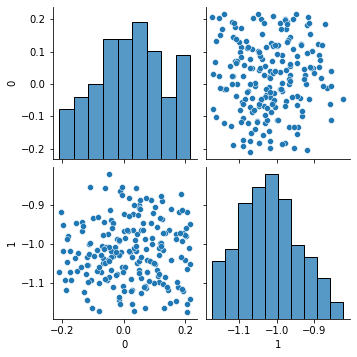

In [77]:
sns.pairplot(pd.DataFrame(xf[0][:, 0:2]))

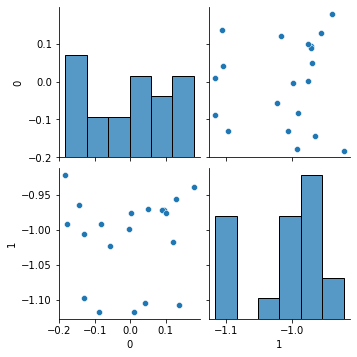

In [78]:
sns.pairplot(pd.DataFrame(xf[1]['10'][:, 0:2]))

# Plotting

In [ ]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)